In [36]:
import rasterio as rio
from rasterio.plot import show
import torch
import segmentation_models_pytorch as smp
from Utils import presentation_utils as pu
import numpy as np
import random
from glob import glob
from termcolor import colored
import os

In [37]:
! rm tmp/predictions/*
! rm tmp/tiles/*
! rm tmp/example.tif

In [38]:
random.seed(51996)
np.random.seed(51996)
torch.manual_seed(51996)

In [39]:
MODELS = {
    "vanilla":12,
    "ben":12,
    "imagenet":10,
    "effis":12
}

Tiling test image...
Loading initial image into memory...
Test image shape: (13, 1357, 1653)
Computing tiles...
Testing model: vanilla; input channels: 12
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  4.82it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)


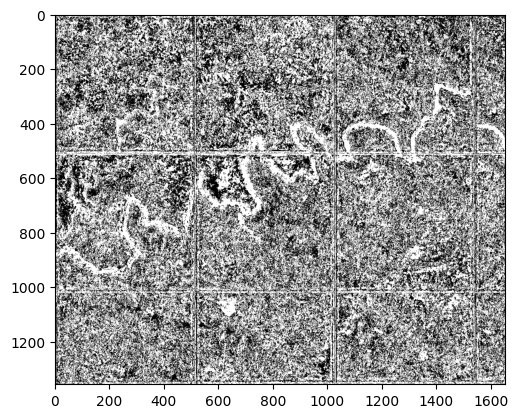

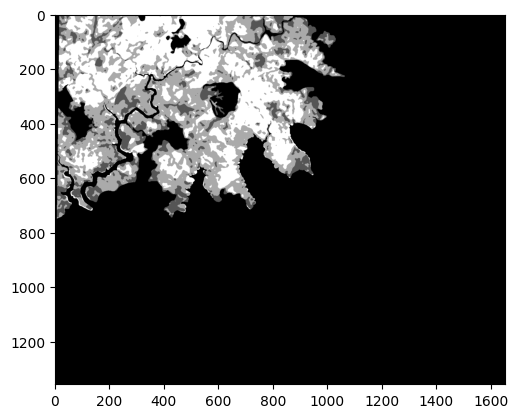

Removing existing predictions...
Testing model: ben; input channels: 12
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  4.57it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)


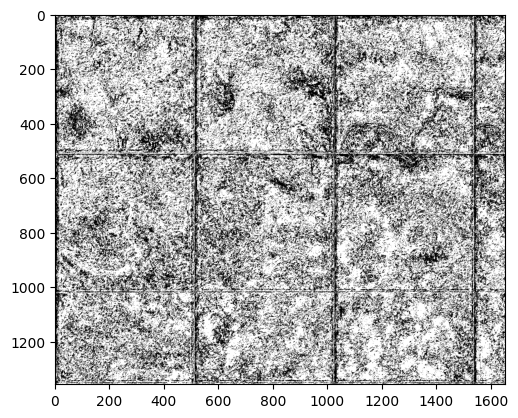

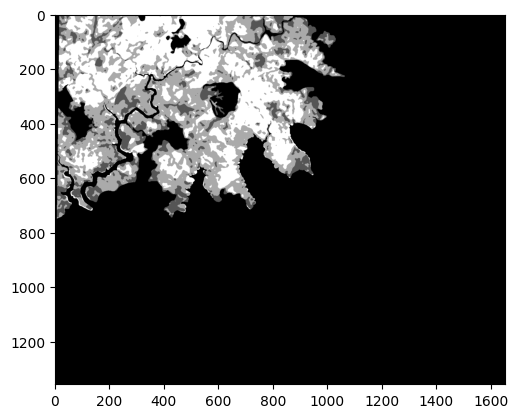

Removing existing predictions...
Testing model: imagenet; input channels: 10
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  4.60it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)


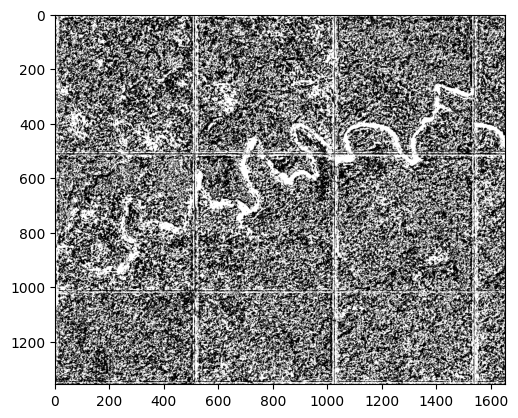

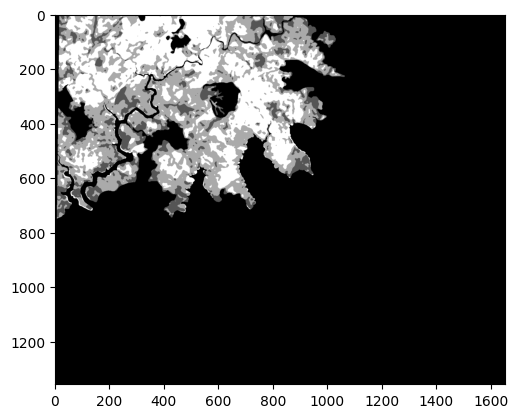

Removing existing predictions...
Testing model: effis; input channels: 12
Making prediction...


100%|██████████| 12/12 [00:02<00:00,  4.52it/s]
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Assembling final prediction...
Empty canvas shape:  (1, 1357, 1653)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)
(1, 1357, 512)


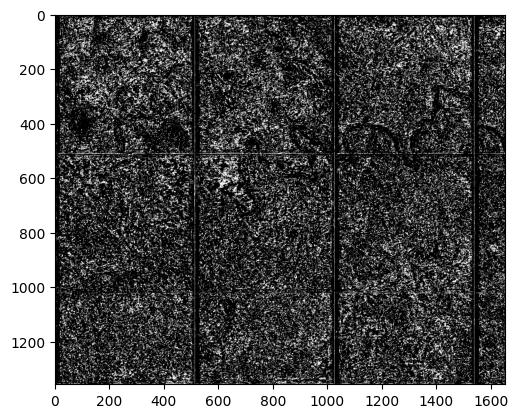

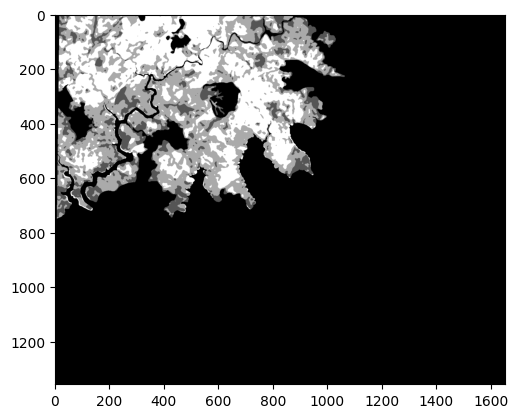

Removing existing predictions...


In [40]:
print("Tiling test image...")
pu.tiling(initial_img_path="tmp/test_img.tiff")
for mdl, in_c in MODELS.items():
    print(colored(f"Testing model: {mdl}; input channels: {in_c}", "red"))
    model = smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=in_c, classes=1)
    model.encoder.load_state_dict(torch.load(f"models/trained_models/{mdl}.pth"), strict=False)
    # print("Tiling test image...")
    # pu.tiling(initial_img_path="tmp/test_img.tiff")
    print("Making prediction...")
    pu.make_predictions(model=model, model_type=mdl)
    print("Assembling final prediction...")
    final_prediction, shape_crop = pu.merge_tiles(test_img_path="tmp/test_img.tiff")
    show(final_prediction[:, :, 512:shape_crop+512], cmap="gray")
    gt_mask = rio.open("tmp/test_mask.tiff", "r").read()
    show(gt_mask, cmap="gray")
    pu.write_results(final_img = final_prediction)
    print(colored(f"Removing existing predictions...", "green"))
    for prediction in glob("tmp/predictions/*.tif"):
        os.remove(prediction)